In [1]:
import json
import pandas as pd
from pandas.io.json import json_normalize
import calendar
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('/Users/inan/Desktop/ultimate_challenge/logins.json')

In [3]:
days = list(calendar.day_abbr)
months = list(calendar.month_abbr)

### Data Wrangling

In [4]:
df['count'] = 1
df = df.set_index('login_time')

In [5]:
df

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1
...,...
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1


In [6]:
ldf = df.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum) 
ldf['count'] = ldf['count'].fillna(0)
ldf.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


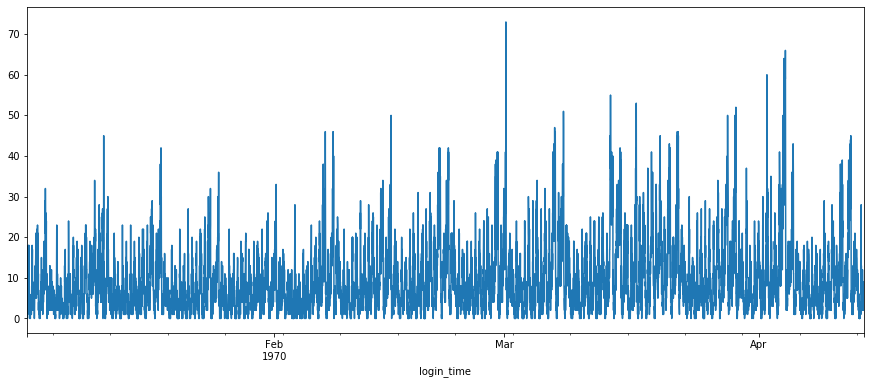

In [7]:
plt.figure(figsize=(15,6))
ldf['count'].plot()

In [8]:
ldf['timestamp'] = pd.to_datetime(ldf.index)

In [9]:
ldf['month'] = ldf['timestamp'].apply(lambda x: months[x.month])
ldf['day'] = ldf['timestamp'].apply(lambda x: days[x.weekday()])
ldf['hour'] = ldf['timestamp'].apply(lambda x: x.hour)
ldf['time'] = ldf['timestamp'].apply(lambda x: x.time())

### Explotary Data Analysis

#### Days

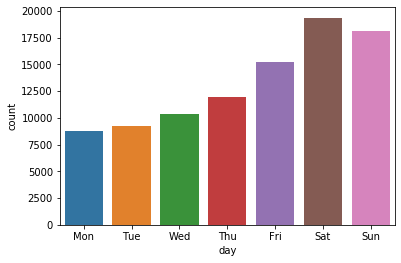

In [10]:
day_counts = ldf.groupby('day')['count'].sum()
sns.barplot(x=day_counts.index, y=day_counts, order=days)

##### Observations

Saturday is the most popular day for users followed by Sunday and Friday respectively.

Monday shows the least activity.

This strongly suggests that users are more active on the platform on the weekends than on the weekdays.

#### Months

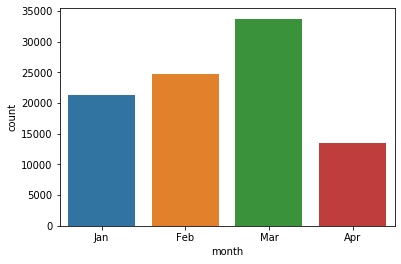

In [11]:
month_counts = ldf.groupby('month')['count'].sum()
sns.barplot(x=month_counts.index, y=month_counts, order=['Jan', 'Feb', 'Mar', 'Apr'])


#### Hours

In [12]:
hour_counts = ldf.groupby('hour')['count'].sum()

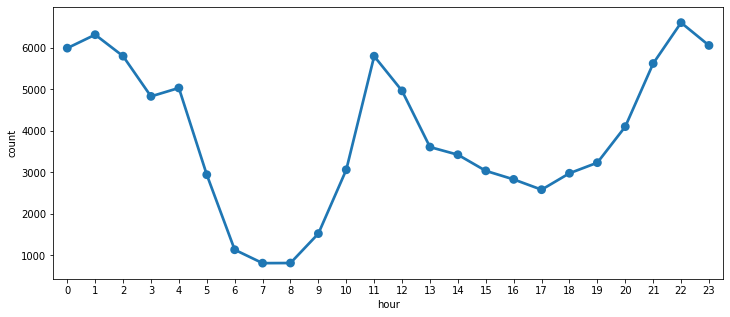

In [13]:
plt.figure(figsize=(12,5))
sns.pointplot(x=hour_counts.index, y=hour_counts)


The graph above shows us the amount of activity recorded every hour of the day.

#### Observations

The platform records maximum activity between 10 PM and 1 AM.

There is also a sharp rise in user activity at around noon.

The least activity is recorded during early morning between 6 AM and 8 AM.

#### 15 Min intervals

In [14]:
time_counts = ldf.groupby('time')['count'].sum()
time_counts.sort_values(ascending=False).head(10)

time
22:30:00    1684
01:30:00    1673
22:15:00    1652
22:45:00    1637
22:00:00    1634
11:30:00    1622
01:15:00    1598
23:00:00    1573
11:45:00    1570
21:45:00    1554
Name: count, dtype: int64

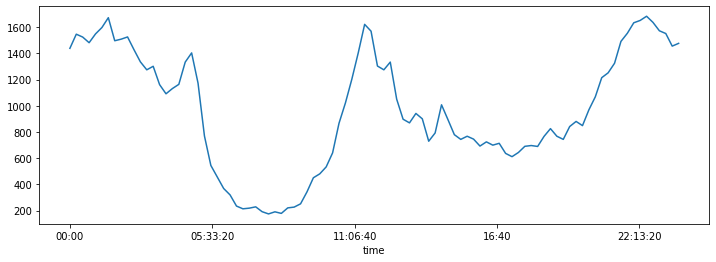

In [15]:
plt.figure(figsize=(12,4))
time_counts.plot()

The shape of this graph closely mirrors that of the graph obtained in the previous subsection. There is not too much additional insights to be gained from this.


## Experiment and Metrics Design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs

### Success Metrics
Note: I'm assuming the demand is equal in both the cities. That is, the demand of cabs in Gotham during the night is the same as the demand of cabs in Metropolis during the day.

We know that the demand in both the cities is complementary in the weekdays; i.e the demand for both cities can be met by the same driver partners as they are at different times. Therefore, if this experiment was indeed sucessful, it would indicate that the drivers, irrespective of which city they belong to, are spending equal amounts of time in Gotham and Metropolis during the weekdays; Metropolis during the day and Gotham during the night.

The success metric I propose is the ratio of passengers taken from Gotham and Metropolis on weekdays. After the introduction of this experiment, if the ratio has regressed towards 1:1, it would mean that the experiment was successful.

### Experiment
These are the steps I will implement as part of an experiment to deduce if the policy changes have affected the behavior of the drivers.

Track the activity of every driver in each city. If the number of Gotham passengers for a particular driver is more, label him/her as a Gotham Driver. Else label as Metropolis Driver.

Calculate the proportion of passengers from two cities and divide them into two sample groups: before the experiment and after the experiment.

Perform hypothesis testing using the Difference of Proportions test on the two samples. Calculate the Z-Statisitc and the p-value and compare it with an arbritrary significance level, $\alpha$.

If the Null Hypothesis holds, it implies that the experiment has been a failure. If the Alternate hypothesis holds, it implies that it has been a success.

I will perform the experiment described above and test if the Null Hypothesis can be rejected for both groups. If this is true, then I will suggest that Ultimate Inc continue implementing this policy change. If it cannot be rejected, then I will suggest that they stop and look for other potent options.

### Predictive Modelling

In [16]:
df2 = pd.read_json('/Users/inan/Desktop/ultimate_challenge/ultimate_data_challenge.json')

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
df2['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

It seems that iPhones are significantly more popular than Android phones. Therefore, we will impute the missing values with iPhone.

In [19]:
df2['phone'] = df2['phone'].fillna('iPhone')

In [20]:
df2['avg_rating_by_driver'].describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

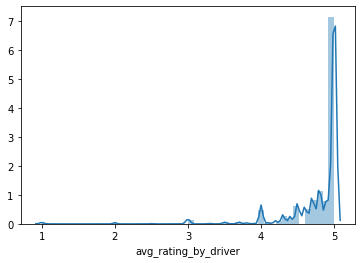

In [21]:
sns.distplot(df2[df2['avg_rating_by_driver'].notnull()]['avg_rating_by_driver'])


The median rating is 5. We will impute the very few missing values we have with 5.

In [22]:
df2['avg_rating_by_driver'] = df2['avg_rating_by_driver'].fillna(df2['avg_rating_by_driver'].median())

In [23]:
df2['avg_rating_of_driver'].describe()


count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

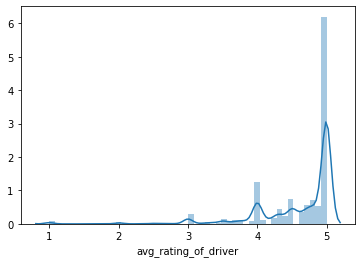

In [24]:
sns.distplot(df2[df2['avg_rating_of_driver'].notnull()]['avg_rating_of_driver'])


Passengers are slightly less lenient with their ratings than drivers. I will just impute the missing values with the mean.



In [25]:
df2['avg_rating_of_driver'] = df2['avg_rating_of_driver'].fillna(df2['avg_rating_of_driver'].mean())


In [26]:
df2['signup_date'] = df2['signup_date'].apply(lambda x: pd.Timestamp(x, tz=None))
df2['last_trip_date'] = df2['last_trip_date'].apply(lambda x: pd.Timestamp(x, tz=None))

In [27]:
df2['last_trip_date'].sort_values(ascending=False).head(10)


45357   2014-07-01
22735   2014-07-01
14473   2014-07-01
38651   2014-07-01
45126   2014-07-01
14419   2014-07-01
38661   2014-07-01
45143   2014-07-01
45154   2014-07-01
45155   2014-07-01
Name: last_trip_date, dtype: datetime64[ns]

We see that this data was taken on 1st July, 2014. Therefore, a user is considered retained if s/he took a trip after June 1st, 2014.

In [28]:
df2['retained'] = df2['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)


In [29]:
df2['retained'].value_counts()


0    31196
1    18804
Name: retained, dtype: int64

We see that Ultimate Inc. has been able to retain 18,804 or 37.6% of its Userbase. This retention rate is not that high.



Since our users have all signed up in January 2014, we can drop it as it doesn't really indicate much.



In [30]:
df2 = df2.drop('signup_date', axis=1)

In [31]:
df2 = df2.drop('last_trip_date', axis=1)

In [32]:
df2['ultimate_black_user'] = df2['ultimate_black_user'].apply(lambda x: 1 if x else 0)


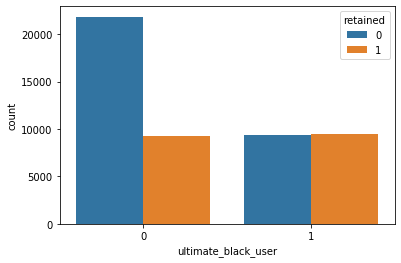

In [33]:
sns.countplot(x='ultimate_black_user', data=df2, hue='retained')

Ultimate Black Users are much more likely to be retained as compared to the rest of the population.



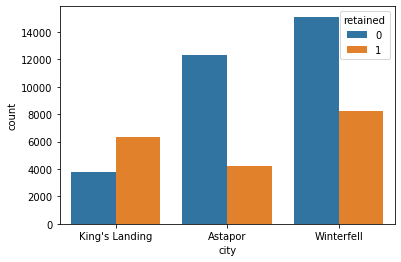

In [34]:
sns.countplot(x='city', data=df2, hue='retained')


King's Landing seems to be especially successful in retaining users whereas Astapor is the least successful.


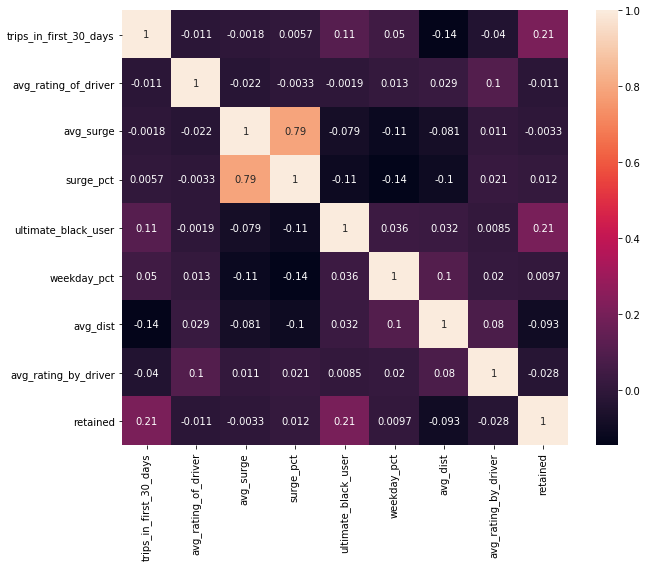

In [35]:
plt.figure(figsize=(10,8))
sns.heatmap(df2.corr(), annot=True)

In [36]:
df2 = pd.get_dummies(df2, prefix='is')


In [37]:
X, y = df2.drop(['retained', 'avg_surge'], axis=1), df2['retained']

In [38]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.85, test_size=0.15, stratify=y)

In [39]:
classifier = GradientBoostingClassifier(verbose=True, n_estimators=200)
classifier.fit(train_X, train_y)
classifier.score(test_X, test_y)

      Iter       Train Loss   Remaining Time 
         1           1.2790            9.68s
         2           1.2425           10.76s
         3           1.2121           11.58s
         4           1.1838           11.84s
         5           1.1606           12.05s
         6           1.1401           12.02s
         7           1.1227           11.73s
         8           1.1070           11.76s
         9           1.0878           11.55s
        10           1.0752           11.40s
        20           0.9931           10.00s
        30           0.9591            9.32s
        40           0.9398            8.61s
        50           0.9290            8.06s
        60           0.9219            7.43s
        70           0.9173            6.84s
        80           0.9138            6.25s
        90           0.9111            5.77s
       100           0.9082            5.18s
       200           0.8873            0.00s


0.7912

Our classifier reports an accuracy of 79.1%. The model that we used was the Gradient Boosting Classifier.

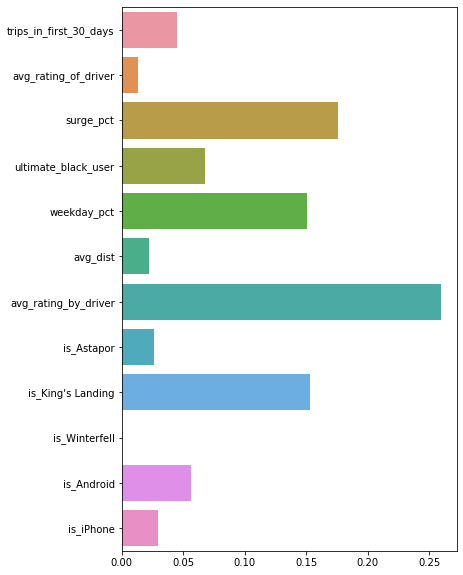

In [40]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=classifier.feature_importances_)

### Recommendations
Increase operations in King's Landing as they tend to have greater probability of conversion. Alternatively, discover what is unique about King's Landing drivers and passengers and check if it can be implemented in the other cities, especially Astapor.

If the user has taken a Ultimate Black, it indicates that s/he is more likely to stay. Provide addtional perks to these people.

People who use cabs on the weekdays are more likely to be retained. This is the most important feature as discovered by our Gradient Boosting Classifier. Provide more offers in the weekdays to encourage people to take cabs to work.